In [ ]:
import os
import random
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, auc as pr_auc, make_scorer
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC

In [2]:
# Load data
data_path = r'E:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\ecg_data.csv'
data = pd.read_csv(data_path, index_col=0)

# Splitting features and labels
x = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [15]:
# Load data
data_path_SVM = r'E:\OneDrive\School\Technical Medicine\TM Jaar 1\Machine learning\TM10007_Machine_Learning_Group_4\TM\TM10007_Machine_Learning_Group_4-1\data\SVM_Final.csv'

SVM_metrics = pd.read_csv(data_path_SVM, index_col=0)


def get_mode_parameters(metrics, parameters):
    """
    Function to calculate the mode of specified parameters from the metrics DataFrame.

    Args:
        metrics (pd.DataFrame): DataFrame containing the metrics data.
        parameters (list): List of parameter column names to calculate the mode for.

    Returns:
        dict: Dictionary with parameter names as keys and their mode as values.
    """
    mode_values = {}
    for param in parameters:
        mode_values[param] = metrics[param].mode()[0]
        print(f"Mode of {param}:", mode_values[param])

    print("\n")
    return mode_values

# Example usage
SVM_parameters= ['svc__C','svc__gamma','svc__class_weight','svc__shrinking','svc__tol']


KNN_mode_values = get_mode_parameters(SVM_metrics, SVM_parameters)



Mode of svc__C: 25.152341288668936
Mode of svc__gamma: 0.0011607092785083
Mode of svc__class_weight: balanced
Mode of svc__shrinking: False
Mode of svc__tol: 0.0006731322632681




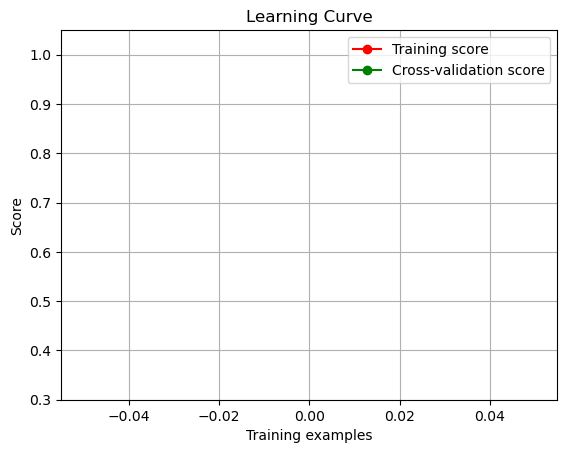

In [13]:
#prior split
X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, stratify=y, shuffle=True, random_state=7)

parameters = {
    'C': 25.152341288668936,
    'gamma': 0.0011607092785083,
    'class_weight': 'balanced',
    'shrinking': False,
    'tol': 0.0006731322632681
}

pipeline = Pipeline([
    ('minmaxscaler', MinMaxScaler(feature_range=(0, 1))),
    ('pca', PCA(n_components=0.99)),
    ('rfc', SVC(kernel='rbf', **parameters, probability=True))
])

pipeline.fit(X_test, y_test)
def pr_auc_score(y_true, y_pred_proba):
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        return pr_auc(recall, precision)
pr_auc_scorer = make_scorer(pr_auc_score, needs_proba=True)

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=7), scoring=pr_auc_scorer, n_jobs=-1)


# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

# Plot the mean and standard deviation for training and test scores
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.ylim(0.3, 1.05)
plt.legend(loc="best")
plt.show()